In [ ]:
import pandas as pd
import numpy as np
from numpy import random
import os

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import albumentations as A
from sklearn.metrics import f1_score
import cv2


### Loading Images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip /content/drive/MyDrive/archive.zip

In [ ]:
directory="/content/pc_parts"

In [ ]:
labels = os.listdir(directory)
labels

#### Creating Dataframe

In [ ]:
def read_data(folder):
    data, label, paths = [], [], []
    for l in labels:
        path = f"{folder}/{l}/"
        folder_data = os.listdir(path)
        for image_path in folder_data:
            img = cv2.imread(path + image_path)
            data.append(img)
            label.append(l)
            paths.append(os.path.join(directory, l, image_path))

    return data, label, paths

In [ ]:
all_data, all_labels, all_paths = read_data(directory)

In [ ]:
df = pd.DataFrame({
    'image':all_data,
    'path': all_paths,
    'label': all_labels
})

> Split into train, test, and valid sets

In [ ]:
train_df, dummy_df=train_test_split(df, train_size=.8, random_state=123, shuffle=True, stratify=df['label'])
valid_df, test_df=train_test_split(dummy_df, train_size=.5, random_state=123, shuffle=True, stratify=dummy_df['label'])
print("Train dataset : ",len(train_df),"Test dataset : ",len(test_df),"Validation dataset : ",len(valid_df))
train_balance=train_df['label'].value_counts()
print('Train dataset value count: \n',train_df['label'].value_counts())

In [ ]:
import plotly.express as px

In [ ]:
px.histogram(train_df, x='label', barmode='group')

> Value counts of all the different labels in train set

### Data Augmentation

In [ ]:
import cv2
import numpy as np

In [ ]:
def apply_transform(image):

    # Rotate (random angle between -40 and 40 degrees)
    angle = np.random.uniform(-40, 40)
    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    image = cv2.warpAffine(image, M, (cols, rows))

    # Horizontal Flip
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)

    # Vertical Flip
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 0)

    # Random Brightness and Contrast
    alpha = 1.0 + np.random.uniform(-0.2, 0.2)  # Brightness
    beta = 0.0 + np.random.uniform(-0.2, 0.2)   # Contrast
    image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

    # Random Gamma Correction
    gamma = np.random.uniform(0.8, 1.2)
    image = np.clip((image / 255.0) ** gamma, 0, 1) * 255.0

    return image

In [ ]:
def apply_augmentation(image_path, label):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    augmented_image = apply_transform(image=image)
    return augmented_image, label

In [ ]:
augmented_data = []
for index, row in train_df.iterrows():
    image_path = row['path']
    label = row['label']
    augmented_image, augmented_label = apply_augmentation(image_path, label)
    augmented_data.append((augmented_image, augmented_label, image_path))

In [ ]:
augmented_df = pd.DataFrame(augmented_data, columns=['object', 'label', 'path'])

In [ ]:
merged_df = pd.concat([train_df, augmented_df], ignore_index=True)

In [ ]:
from collections import Counter

In [ ]:
class_counts = Counter(merged_df['label'])
min_class_count = min(class_counts.values())

balanced_data = []
for label, count in class_counts.items():
    class_samples = merged_df[merged_df['label'] == label].sample(min_class_count)
    balanced_data.append(class_samples)

balanced_df = pd.concat(balanced_data)

In [ ]:
balanced_df['label'].value_counts()

In [ ]:
gen=ImageDataGenerator()

In [ ]:
train_gen=gen.flow_from_dataframe(balanced_df, x_col='path', y_col='label', target_size=(255,255),seed=123,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=32)

In [ ]:
val_gen=gen.flow_from_dataframe(valid_df, x_col='path', y_col='label', target_size=(255,255),seed=123,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=32)

In [ ]:
test_gen=gen.flow_from_dataframe(test_df, x_col='path', y_col='label', target_size=(255,255),seed=123,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=32)

#### base CNN model (sequential)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D
import tensorflow as tf

In [ ]:
initializer = tf.keras.initializers.HeNormal()

In [ ]:
model=Sequential()
model.add(Convolution2D(filters=32, kernel_size=3, padding='same', activation="relu",
                           input_shape=(255, 255, 3)))
model.add(MaxPooling2D(strides=2, pool_size=2, padding= "valid"))
model.add(Convolution2D(filters=32, kernel_size=2, padding='same', activation="relu"))
model.add(MaxPooling2D(strides=2, pool_size=2, padding="valid"))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(14, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_gen, validation_data= val_gen, batch_size=  32, epochs = 10, verbose = 1)

> CNN model is giving very low validation accuracy


#### Transfer learning with EfficientNetV2B1

In [ ]:
base_model=tf.keras.applications.EfficientNetV2B1(include_top=False, weights="imagenet",input_shape=(255,255,3), pooling='max')
print('Created EfficientNetV2 B1 model')

In [ ]:
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)
output=Dense(14, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
rlronp=keras.callbacks.ReduceLROnPlateau( monitor="val_loss", factor=0.4, patience=2, verbose=1, mode="auto",  min_delta=0.00001, cooldown=0, min_lr=0.0)
estop=keras.callbacks.EarlyStopping( monitor="val_loss", min_delta=0,  patience=2, verbose=1, mode="auto", baseline=None, restore_best_weights=True)
callbacks=[rlronp, estop]



```
# This is formatted as code
```

> Model fitting (5 epochs)

In [ ]:
history=model.fit(x=train_gen,   epochs=5, verbose=1, callbacks=callbacks,  validation_data=val_gen,
                   validation_steps=None,  shuffle=True)

Epoch 1/5
100/100 [==============================] - 94s 408ms/step - loss: 8.3788 - accuracy: 0.5689 - val_loss: 7.3754 - val_accuracy: 0.7226 - lr: 0.0010
Epoch 2/5
100/100 [==============================] - 33s 329ms/step - loss: 6.1535 - accuracy: 0.8371 - val_loss: 5.9389 - val_accuracy: 0.7317 - lr: 0.0010
Epoch 3/5
100/100 [==============================] - 34s 337ms/step - loss: 4.8482 - accuracy: 0.9026 - val_loss: 4.9605 - val_accuracy: 0.7561 - lr: 0.0010
Epoch 4/5
100/100 [==============================] - 33s 332ms/step - loss: 3.8367 - accuracy: 0.9377 - val_loss: 4.0890 - val_accuracy: 0.7409 - lr: 0.0010
Epoch 5/5
100/100 [==============================] - 34s 336ms/step - loss: 3.0479 - accuracy: 0.9477 - val_loss: 3.4138 - val_accuracy: 0.7500 - lr: 0.0010


In [ ]:
import matplotlib.pyplot as plt

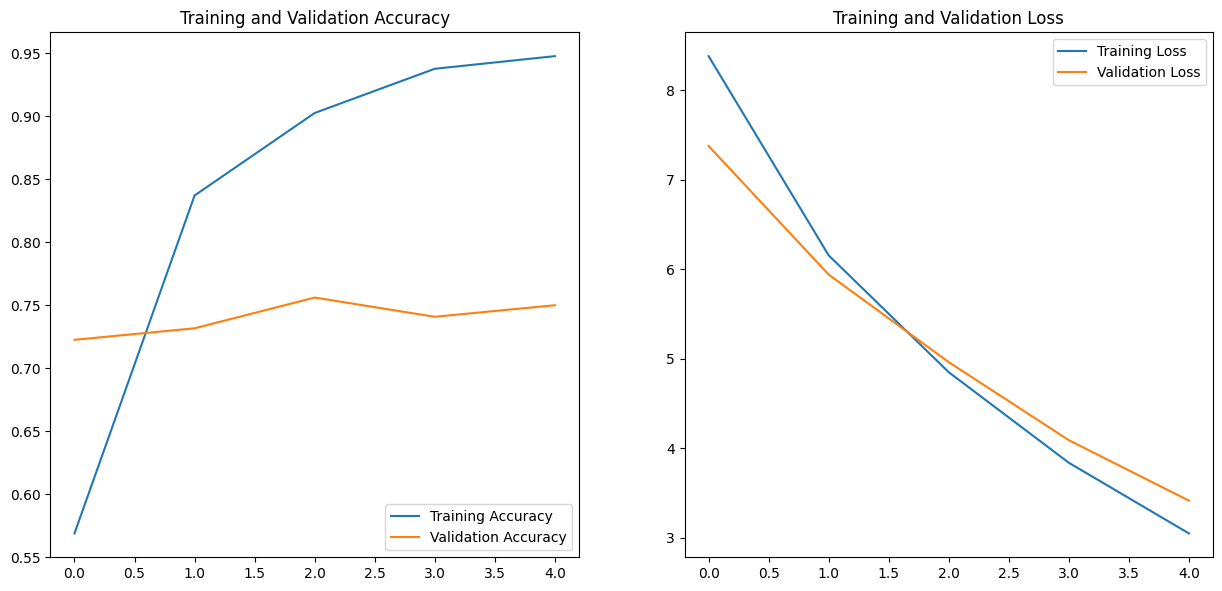

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

> fig-1 : Training accurracy is increasing consistently and validation is increasing and plateaued small signs of overfitting but still model perforamance is expected good!

> fig-2: Training and validation loss is decreasing ,a good sign of perforamnace but, after a point training loss is decreasing more than validation which is that model is getting trained well over some hidden features, overfitting may occur but model is expected to perform well!

In [ ]:
import seaborn as sns

In [ ]:
def predictor(model,test_gen):
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    preds=model.predict(test_gen, verbose=1)
    errors=0
    pred_indices=[]
    test_count =len(preds)
    for i, p in enumerate (preds):
        pred_index=np.argmax(p)
        pred_indices.append(pred_index)
        true_index= test_gen.labels[i]
        if  pred_index != true_index:
            errors +=1
    accuracy = (test_count-errors)*100/test_count
    ytrue=np.array(test_gen.labels, dtype='int')
    ypred=np.array(pred_indices, dtype='int')
    msg=f'There were {errors} errors in {test_count} tests for an accuracy of {accuracy:6.2f}'
    print (msg)
    cm = confusion_matrix(ytrue, ypred )
    # plot the confusion matrix
    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
    plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    clr = classification_report(ytrue, ypred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return

11/11 [==============================] - 3s 93ms/step
There were 71 errors in 328 tests for an accuracy of  78.35


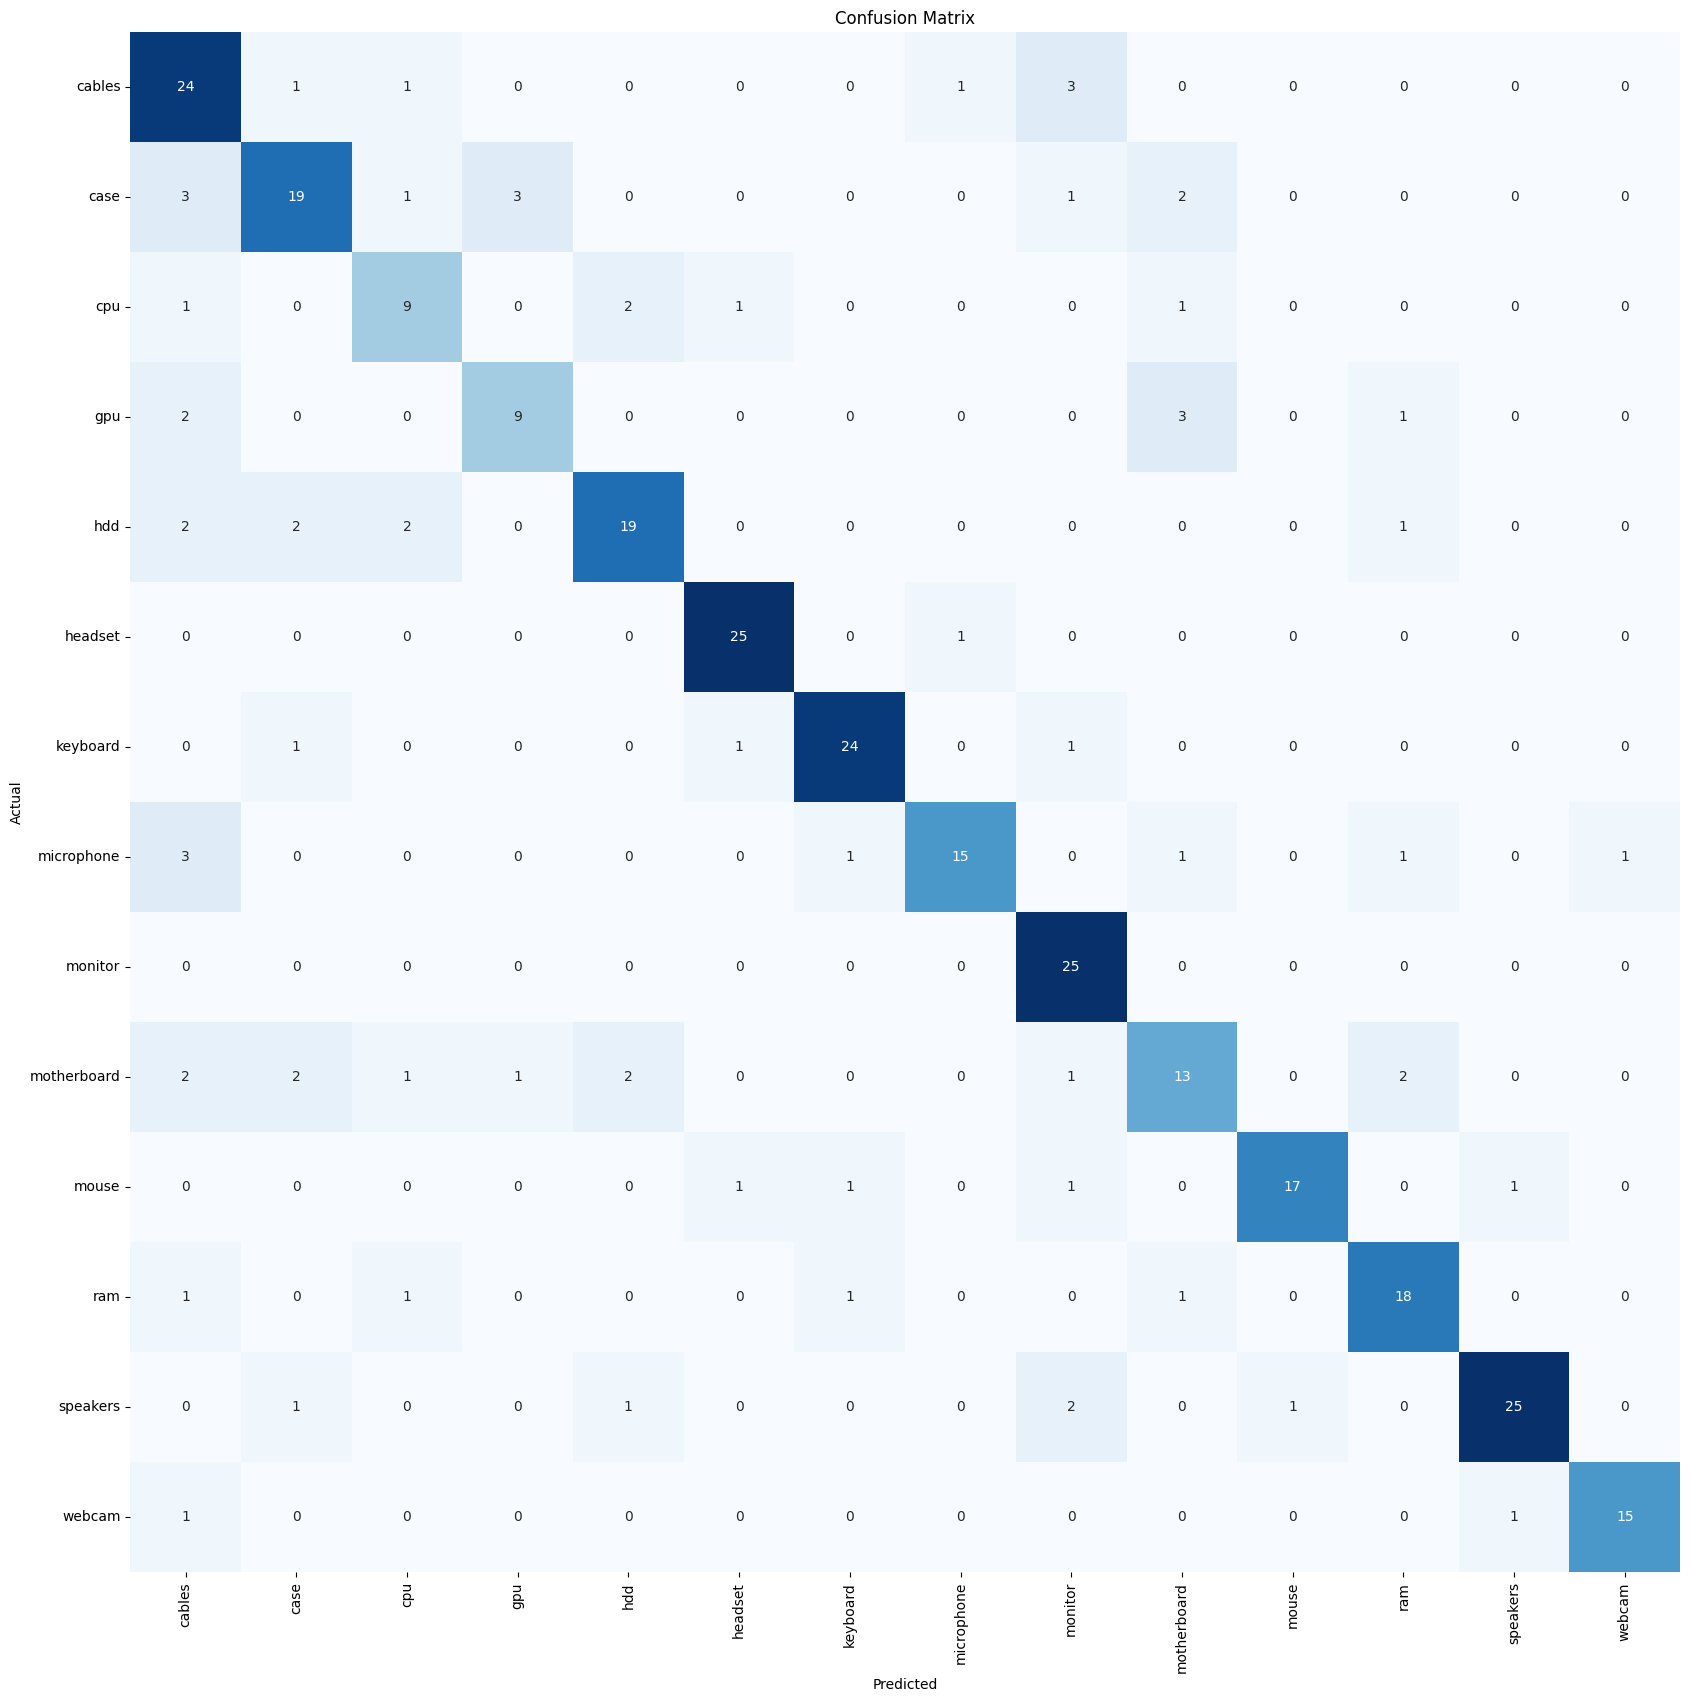

Classification Report:
----------------------
               precision    recall  f1-score   support

      cables     0.6154    0.8000    0.6957        30
        case     0.7308    0.6552    0.6909        29
         cpu     0.6000    0.6429    0.6207        14
         gpu     0.6923    0.6000    0.6429        15
         hdd     0.7917    0.7308    0.7600        26
     headset     0.8929    0.9615    0.9259        26
    keyboard     0.8889    0.8889    0.8889        27
  microphone     0.8824    0.6818    0.7692        22
     monitor     0.7353    1.0000    0.8475        25
 motherboard     0.6190    0.5417    0.5778        24
       mouse     0.9444    0.8095    0.8718        21
         ram     0.7826    0.8182    0.8000        22
    speakers     0.9259    0.8333    0.8772        30
      webcam     0.9375    0.8824    0.9091        17

    accuracy                         0.7835       328
   macro avg     0.7885    0.7747    0.7770       328
weighted avg     0.7916    0.7835

In [ ]:
predictor(model,test_gen) # make predictions on test set

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [ ]:
test_set = ['/content/pc_parts/webcam/109.jpg','/content/pc_parts/cables/105.jpg','/content/pc_parts/case/103.jpg',
            '/content/pc_parts/cpu/110.jpg', '/content/pc_parts/gpu/127.jpg', '/content/pc_parts/hdd/11.jpg',
            '/content/pc_parts/headset/107.jpg', '/content/pc_parts/keyboard/108.jpg', '/content/pc_parts/microphone/103.jpg',
            '/content/pc_parts/monitor/104.jpg', '/content/pc_parts/motherboard/105.jpg', '/content/pc_parts/mouse/102.jpg',
            '/content/pc_parts/ram/101.jpg','/content/pc_parts/speakers/10.jpg'
            ]

In [ ]:
labels.sort()

In [ ]:
labels

['cables',
 'case',
 'cpu',
 'gpu',
 'hdd',
 'headset',
 'keyboard',
 'microphone',
 'monitor',
 'motherboard',
 'mouse',
 'ram',
 'speakers',
 'webcam']

In [ ]:
def get_model_prediction(image_path):
    img = load_img(image_path, target_size=(255, 255))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x, verbose=0)
    return labels[predictions.argmax()]

### Saving Model

In [ ]:
model.save("model.h5")
print("Saved model to disk")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



Saved model to disk


### Manual Testing

In [ ]:
pred = []
for file in test_df['path'].values:
    pred.append(get_model_prediction(file))

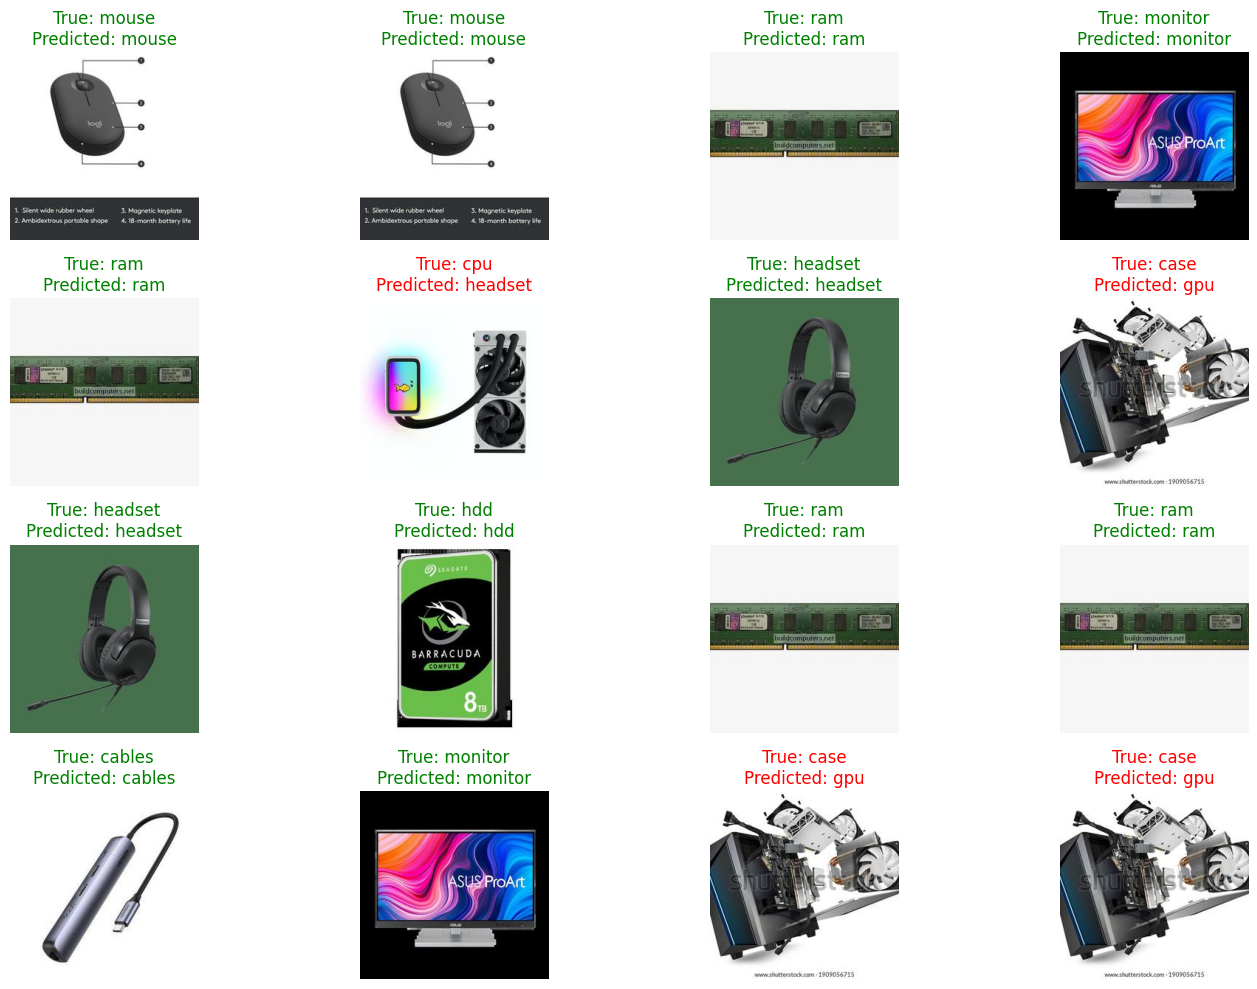

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 10))
random_index = np.random.randint(0, len(test_gen), 16)

for i, ax in enumerate(axes.ravel()):
    img_path = test_df['path'].iloc[random_index[i]]

    ax.imshow( load_img(img_path))
    ax.axis('off')

    if test_df['label'].iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"

    ax.set_title(f"True: {test_df['label'].iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)

plt.tight_layout()
plt.show()

In [ ]:
!pip show tensorflow-estimator

Name: tensorflow-estimator
Version: 2.15.0
Summary: TensorFlow Estimator.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: 
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: tensorflow


In [ ]:
!pip3 freeze > requirements.txt